# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

---

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.
오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다.   
여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.  

---

- OCR 접목 서비스  
ocr 서비스가 적절하게 사용될 수  있는 분야로 책을 분류하는 모델을 만들도록 한다.  
기본적인 폰트의 책부터 손글씨와 같은 폰트 등의 제목도 바르게 인식해보는지 확인해 본다.

## Step 1. 검증용 데이터셋 준비

OCR을 적용해볼 책 표지들을 불러옵니다.

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output



In [2]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/image'
data_path

'/aiffel/aiffel/ocr_python/image'

In [3]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/image/1.jpg',
 '/aiffel/aiffel/ocr_python/image/2.jpg',
 '/aiffel/aiffel/ocr_python/image/3.jpg']

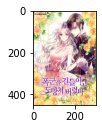

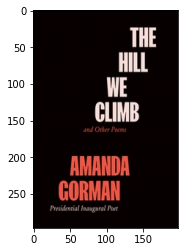

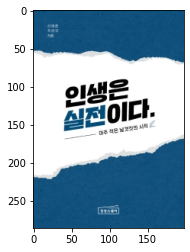

In [4]:
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(5, 3, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.show()

1~5번은 다양한 책표지  
6번은 모두의 연구소 배경  
7번은 식당 간판과 메뉴판 일부입니다.  



## Step 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1. Google OCR API

In [ ]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/spry-scope-326515-82b7e7a9ea09.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+ '/aiffel/ocr_python/image/1.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

### 2. keras-ocr

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


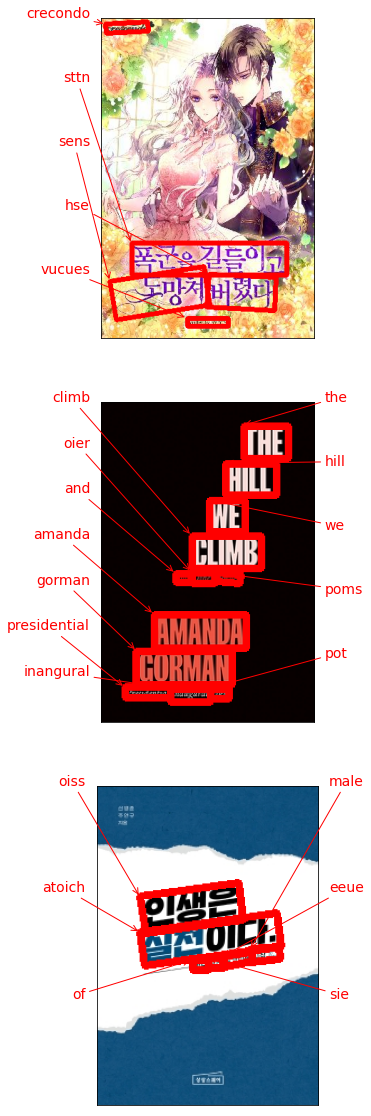

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract

In [41]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [42]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
img_file_path = work_dir + '/1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

In [43]:
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png


SystemError: tile cannot extend outside image

In [45]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [46]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

NameError: name 'cropped_image_path_list' is not defined

## Step 3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

## Step 4. 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

---

## 루브릭 관련 고려한 점

**1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?**

- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

**2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?**

- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

**3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?**

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## 회고
1️⃣ 잘한 점:

- 00

2️⃣ 어려웠던 점:

- 00

3️⃣ 느낀 점:

- 00 수정전 파일